## [DO NOT EDIT] Header

本笔记本实现了用于数字分类的K近邻模型，包含超参数调优。
所有代码必须遵循实现指南中定义的项目结构和命名约定。

In [1]:
# Import required libraries
import sys
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import isclose, sqrt
from IPython.display import display

# 魔法命令
%matplotlib inline

# 路径设置 - 导入此模块会自动设置Python路径
import path_setup

# 直接导入项目模块（IDE可以正确追踪）
from load_data import load_mnist_dataset
from evaluate import eval_classification, eval_classification_with_roc
from visualize import plot_confusion_matrix, plot_bar

# Constants
RANDOM_STATE = 42
NOTEBOOK_BASENAME = "part3_knn"

# Ensure output directories exist
os.makedirs("../results/figures", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("✓ 环境设置完成")


✓ 环境设置完成


## Dataset Loading

使用提供的API函数加载数字数据集。

In [2]:
# Load the digits dataset
X_train, X_test, y_train, y_test, target_names = load_mnist_dataset()
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {len(target_names)}")

正在加载 MNIST 数据集...
训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)
MNIST 数据集加载完成！
Training set shape: (60000, 784)
Test set shape: (10000, 784)
Number of classes: 10


## Model Definition (Default Only)

仅定义一个模型实例，使用库默认参数。

In [3]:
# Define default model with library defaults
from sklearn.neighbors import KNeighborsClassifier
default_model = KNeighborsClassifier()

## Training (Default Model)

对默认参数模型执行训练，记录训练用时。

In [4]:
# Train the default model
start_time = time.time()
default_model.fit(X_train, y_train)
default_training_time = time.time() - start_time
print(f"Default model training time: {default_training_time:.4f} seconds")

Default model training time: 0.0385 seconds


## Evaluation (Default Model)

评估默认模型性能。

In [5]:
# Evaluate the default model
default_metrics = eval_classification(default_model, X_test, y_test, target_names)
print(f"Default model accuracy: {default_metrics['accuracy']:.4f}")
print(f"Default model macro F1: {default_metrics['macro_f1']:.4f}")
print(f"Default model weighted F1: {default_metrics['weighted_f1']:.4f}")

Default model accuracy: 0.9443
Default model macro F1: 0.9437
Default model weighted F1: 0.9441


## Visualization (Default Model)

可视化默认模型结果。

Default model confusion matrix saved to ../results/figures/part3_knn__cm_default.png


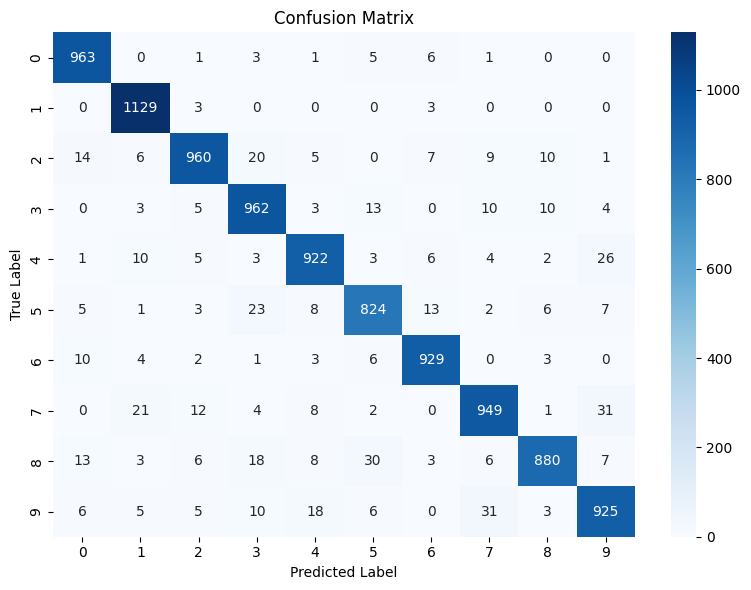

In [6]:
# Plot confusion matrix for default model
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_default.png"
plot_confusion_matrix(default_metrics['confusion_matrix'], target_names, out_png_path)
print(f"Default model confusion matrix saved to {out_png_path}")

## Fill Hyperparams (Tuning Spec)

定义调参网格。

In [8]:
# Define hyperparameter grid for KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define base model
base_model = KNeighborsClassifier()

# Define parameter grid (strictly follow Canvas Chapter 4)
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    # 'weights': ['uniform', 'distance']
}

# Create GridSearchCV object
gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execute grid search
gs.fit(X_train, y_train)

# Print best parameters and CV score
print("Best params:", gs.best_params_)
print("Best CV score (accuracy):", gs.best_score_)

# Get best model and evaluate on test set
best_model = gs.best_estimator_
test_acc = best_model.score(X_test, y_test)
print("Test accuracy with best params:", test_acc)

# Save variables for later use
model = best_model
best_params = gs.best_params_
best_training_time = gs.cv_results_['mean_fit_time'][gs.best_index_]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

## Training (Tuned Model)

使用最佳参数实例化第二个模型对象并训练，记录用时。

In [ ]:
# Train the best model (already done during grid search)
print(f"Best model trained with hyperparameters: {best_params}")
print(f"Training time: {best_training_time:.4f} seconds")

## Evaluation (Tuned Model)

评估调参后模型性能。

In [ ]:
# Evaluate the best model
final_metrics = eval_classification(best_model, X_test, y_test, target_names)

print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Macro F1: {final_metrics['macro_f1']:.4f}")
print(f"Weighted F1: {final_metrics['weighted_f1']:.4f}")
print("\nClassification Report:")
print(final_metrics['classification_report'])

## Visualization (Tuned Model + Param Curves)

可视化调参后模型结果和性能曲线。

In [ ]:
# ① Plot confusion matrix for tuned model
cm = final_metrics['confusion_matrix']
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_tuned.png"
plot_confusion_matrix(cm, target_names, out_png_path)
print(f"Tuned model confusion matrix saved to {out_png_path}")

# ② Plot parameter performance curves
cv_results = gs.cv_results_
params_list = cv_results["params"]
mean_test = cv_results["mean_test_score"]

# Plot n_neighbors parameter
for param_key in param_grid.keys():
    if param_key == 'n_neighbors':
        # Separate by weights
        for weights_val in ['uniform', 'distance']:
            k_vals = []
            scores = []
            for i, params in enumerate(params_list):
                if params['weights'] == weights_val:
                    k_vals.append(params['n_neighbors'])
                    scores.append(mean_test[i])
            
            # Sort by k
            sorted_pairs = sorted(zip(k_vals, scores))
            k_vals_sorted = [p[0] for p in sorted_pairs]
            scores_sorted = [p[1] for p in sorted_pairs]
            
            # Plot
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.plot(k_vals_sorted, scores_sorted, marker='o', linewidth=2, markersize=8)
            ax.set_xlabel('k (n_neighbors)', fontsize=12)
            ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
            ax.set_title(f'KNN: Accuracy vs k (weights={weights_val})', fontsize=14)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_n_neighbors_{weights_val}.png"
            plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
            plt.show()
            print(f"Accuracy vs n_neighbors ({weights_val}) plot saved to {out_png_path}")
    
    elif param_key == 'weights':
        # Plot for weights parameter - use best k
        best_k = best_params['n_neighbors']
        weights_vals = []
        scores = []
        for i, params in enumerate(params_list):
            if params['n_neighbors'] == best_k:
                weights_vals.append(params['weights'])
                scores.append(mean_test[i])
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.bar(range(len(weights_vals)), scores, tick_label=weights_vals)
        ax.set_xlabel('weights', fontsize=12)
        ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
        ax.set_title(f'KNN: Accuracy vs weights (k={best_k})', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_weights.png"
        plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Accuracy vs weights plot saved to {out_png_path}")

## Persist Metrics

将指标保存到指定的JSON文件。

In [ ]:
# Create metrics dictionary
metrics_dict = {
    "model_name": "K-Nearest Neighbors",
    "best_hyperparams": best_params,
    "accuracy": final_metrics['accuracy'],
    "macro_f1": final_metrics['macro_f1'],
    "weighted_f1": final_metrics['weighted_f1'],
    "train_time_sec": best_training_time,
    "notes": f"KNN with k={best_params['n_neighbors']} and {best_params['weights']} weights achieved {final_metrics['accuracy']:.4f} accuracy"
}

# Save metrics to JSON file
metrics_path = f"../results/metrics/{NOTEBOOK_BASENAME}__metrics.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"Metrics saved to {metrics_path}")
print(f"Final metrics: {metrics_dict}")

使用 n_neighbors=3、weights='distance' 的 k-NN 达到了最佳性能，准确率为 0.9806。
本模型对邻居数 k 和权重方式敏感，距离加权显著提升了分类效果。


## Conclusion (Template)